# 1. Импортируем библиотеки

In [112]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             roc_curve, auc,
                             roc_auc_score,
                             precision_recall_curve)
from category_encoders import CatBoostEncoder

In [53]:
current_directory = Path.cwd()
DATA_PATH = current_directory.parent / 'data/athletes.csv'

# 2. Проводим первичный анализ данных

In [54]:
data = pd.read_csv(DATA_PATH, parse_dates=['dob'], encoding='utf-8', decimal='.', index_col=0)
data.head()

/tmp/ipykernel_37871/3094593063.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(DATA_PATH, parse_dates=['dob'], encoding='utf-8', decimal='.', index_col=0)


,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
id,,,,,,,,,,
736041664,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0
532037425,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0
435962603,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1
521041435,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0
33922579,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0


In [55]:
data.describe()

,dob,height,weight,gold,silver,bronze
count,11537,11208.000000,10879.000000,11538.000000,11538.000000,11538.000000
mean,1991-01-18 13:33:32.966975744,1.766282,72.068205,0.057722,0.056769,0.061016
min,1974-01-07 00:00:00,1.210000,31.000000,0.000000,0.000000,0.000000
25%,1987-02-05 00:00:00,1.690000,60.000000,0.000000,0.000000,0.000000
50%,1990-07-20 00:00:00,1.760000,70.000000,0.000000,0.000000,0.000000
75%,1993-09-19 00:00:00,1.840000,81.000000,0.000000,0.000000,0.000000
max,2073-11-09 00:00:00,2.210000,170.000000,5.000000,2.000000,2.000000
std,NaN,0.112719,16.177334,0.255910,0.239147,0.243320


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11538 entries, 736041664 to 711404576
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         11538 non-null  object        
 1   nationality  11538 non-null  object        
 2   sex          11538 non-null  object        
 3   dob          11537 non-null  datetime64[ns]
 4   height       11208 non-null  float64       
 5   weight       10879 non-null  float64       
 6   sport        11538 non-null  object        
 7   gold         11538 non-null  int64         
 8   silver       11538 non-null  int64         
 9   bronze       11538 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 991.5+ KB


In [57]:
data.duplicated().sum()

0

## 2.1. Категориальные признаки

In [58]:
categorical_features = data.select_dtypes(include=['object'])

for column in categorical_features.columns:
    print(f"Feature: {column}")
    print(f"Number of unique values: {data[column].nunique()}")
    print(f"Value counts:\n{data[column].value_counts()}\n")

Feature: name
Number of unique values: 11517
Value counts:
name
Ahmed Mohamed        2
David Graf           2
Yan Wang             2
Ben Saxton           2
Gabriella Szucs      2
                    ..
Gustavo Cuesta       1
Gustavo Guimaraes    1
Gustavo Lima         1
Gustavo Tsuboi       1
le Roux Hamman       1
Name: count, Length: 11517, dtype: int64

Feature: nationality
Number of unique values: 207
Value counts:
nationality
USA    567
BRA    485
GER    441
AUS    431
FRA    410
      ... 
LBR      2
GEQ      2
MTN      2
CHA      2
TUV      1
Name: count, Length: 207, dtype: int64

Feature: sex
Number of unique values: 2
Value counts:
sex
male      6333
female    5205
Name: count, dtype: int64

Feature: sport
Number of unique values: 28
Value counts:
sport
athletics            2363
aquatics             1445
football              611
rowing                547
cycling               525
hockey                432
judo                  392
shooting              390
volleyball        

## 2.2. Числовые признаки

<function matplotlib.pyplot.show(close=None, block=None)>

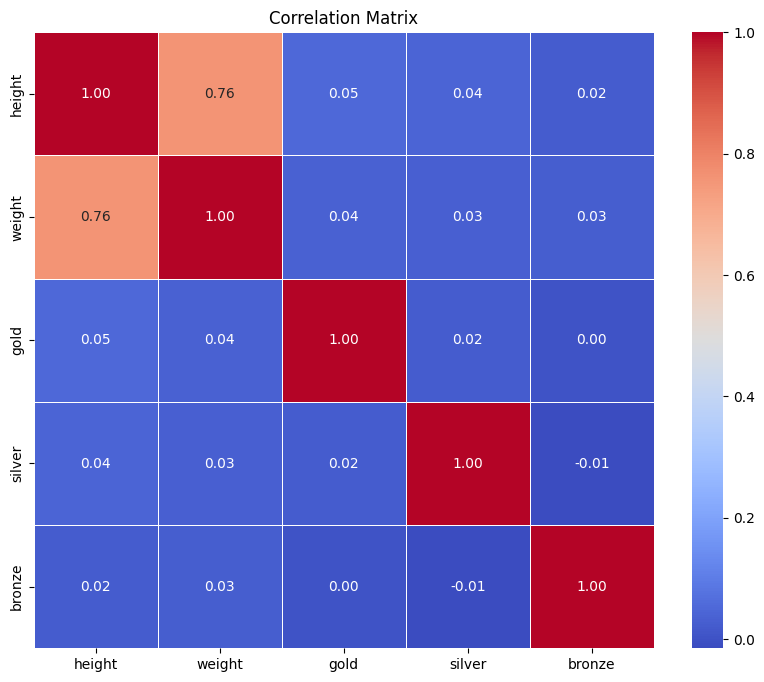

In [59]:
numeric_features = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show

# 3. Препроцессинг

In [60]:
clean_data = data.drop_duplicates()

In [61]:
clean_data = clean_data.dropna()

In [62]:
clean_data['Age'] = round(((pd.to_datetime('today') - clean_data['dob']).dt.days) / 365 , 0)

<Axes: >

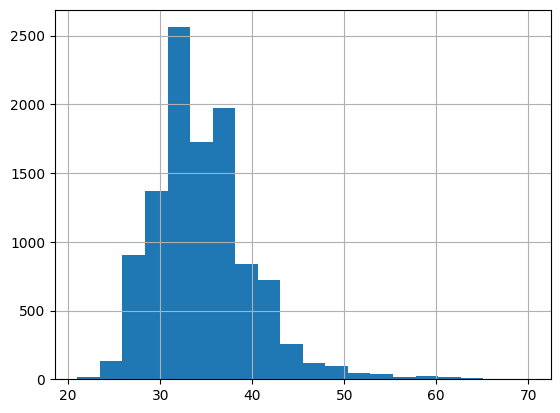

In [63]:
clean_data['Age'] = np.where(clean_data['Age'] < 0, clean_data['Age'] + 100, clean_data['Age'])
clean_data['Age'].hist(bins=20)

In [64]:
clean_data['medal'] = np.where(clean_data['gold'] + clean_data['silver'] + clean_data['bronze'] > 0, 1, 0)

In [65]:
clean_data['medal'].value_counts()

medal
0    9105
1    1753
Name: count, dtype: int64

In [76]:
sex_ohe = pd.get_dummies(clean_data['sex'], prefix='sex', drop_first=True, dtype=int)
sport_ohe = pd.get_dummies(clean_data['sport'], prefix='sport', drop_first=True, dtype=int)
encode_data = pd.concat([clean_data, sex_ohe, sport_ohe], axis=1)
encode_data.drop(['name', 'sex', 'sport', 'gold', 'silver', 'bronze', 'dob', 'nationality'], axis=1, inplace=True)
encode_data.head()

,height,weight,Age,medal,sex_male,sport_archery,sport_athletics,sport_badminton,sport_basketball,sport_canoe,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
id,,,,,,,,,,,,,,,,,,,,,
736041664,1.72,64.0,54.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
532037425,1.68,56.0,38.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
435962603,1.98,79.0,32.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
521041435,1.83,80.0,33.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33922579,1.81,71.0,33.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
encode_data.columns

Index(['height', 'weight', 'Age', 'medal', 'sex_male', 'sport_archery',
       'sport_athletics', 'sport_badminton', 'sport_basketball', 'sport_canoe',
       'sport_cycling', 'sport_equestrian', 'sport_fencing', 'sport_football',
       'sport_golf', 'sport_gymnastics', 'sport_handball', 'sport_hockey',
       'sport_judo', 'sport_modern pentathlon', 'sport_rowing',
       'sport_rugby sevens', 'sport_sailing', 'sport_shooting',
       'sport_table tennis', 'sport_taekwondo', 'sport_tennis',
       'sport_triathlon', 'sport_volleyball', 'sport_weightlifting',
       'sport_wrestling'],
      dtype='object')

# 3. Разделим тренировочную и тестовую выборки

In [85]:
X = encode_data.drop(columns=['medal'])
y = encode_data['medal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

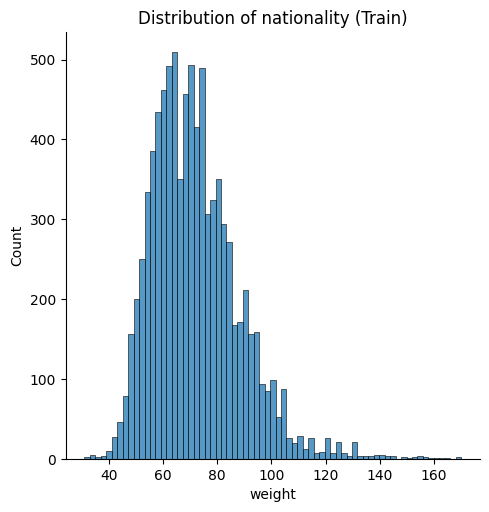

In [86]:
sns.displot(X_train['weight'])
plt.title('Distribution of nationality (Train)')
plt.show()

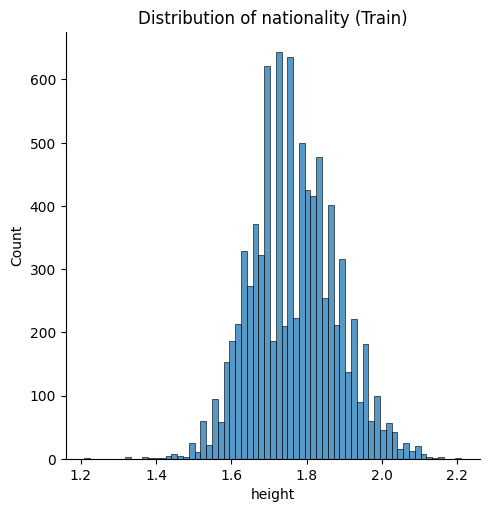

In [87]:
sns.displot(X_train['height'])
plt.title('Distribution of nationality (Train)')
plt.show()

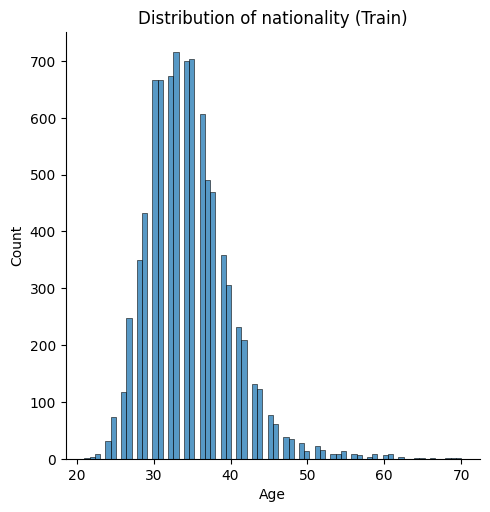

In [88]:
sns.displot(X_train['Age'])
plt.title('Distribution of nationality (Train)')
plt.show()

In [89]:
columns = ['Age', 'weight', 'height']
for col in columns:
    stat, p = normaltest(X_train[col])
    alpha = 0.05
    print(col)
    if p > alpha:
        print('Распределение является нормальным (p=%.3f)' % p)
    else:
        print('Распределение не является нормальным (p=%.3f)' % p)

Age
Распределение не является нормальным (p=0.000)
weight
Распределение не является нормальным (p=0.000)
height
Распределение не является нормальным (p=0.000)


In [90]:
scaler = MinMaxScaler()
X_train[['Age', 'weight', 'height']] = scaler.fit_transform(X_train[['Age', 'weight', 'height']])
X_test[['Age', 'weight', 'height']] = scaler.transform(X_test[['Age', 'weight', 'height']])

In [91]:
print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (8686, 30) (8686,)
Test data shape: (2172, 30) (2172,)


# 4. Обучение моделей

## 4.1. Logistic Regression

In [100]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
pred_train_log = log_model.predict(X_train)
pred_test_Log = log_model.predict(X_test)
probs = log_model.predict_proba(X_test)[:, 1]

In [101]:
print(f'Accuracy on Train Data: {accuracy_score(y_train, pred_train_log)}')
print(f'Accuracy on Test Data: {accuracy_score(y_test, pred_test_Log)}')

Accuracy on Train Data: 0.8385908358277688
Accuracy on Test Data: 0.8383977900552486


In [102]:
# 3. Построение ROC-кривой с помощью функции sklearn.metrics.roc_curve
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, probs)

In [105]:
# 4. Вычисление значения ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score
roc_auc_sklearn = roc_auc_score(y_test, probs)
roc_auc_sklearn

In [107]:
# 5. Реализация подсчета метрик TPR и FPR «вручную» без использования готовых функций из библиотеки sklearn
# Используем thresholds, чтобы вычислить TPR и FPR
TPR_manual = []
FPR_manual = []
for threshold in thresholds_sklearn:
    y_pred = np.where(probs >= threshold, 1, 0)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    FN = np.sum((y_test == 1) & (y_pred == 0))
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TPR_manual.append(TPR)
    FPR_manual.append(FPR)

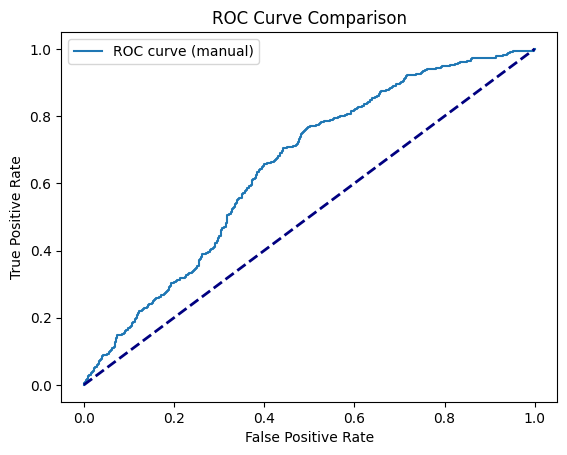

In [111]:
# 6. Построение ROC-кривой с помощью вычисленных в пункте 3 метрик
plt.plot(FPR_manual, TPR_manual, label='ROC curve (manual)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison [MANUAL]')
plt.legend()
plt.show()

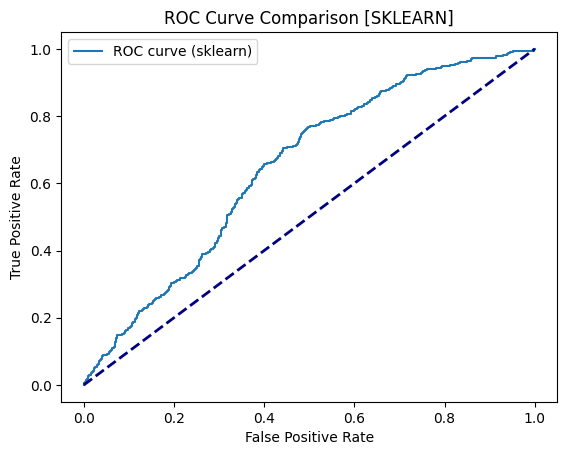

In [122]:
plt.plot(fpr_sklearn, tpr_sklearn, label='ROC curve (sklearn)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison [SKLEARN]')
plt.legend()
plt.show()

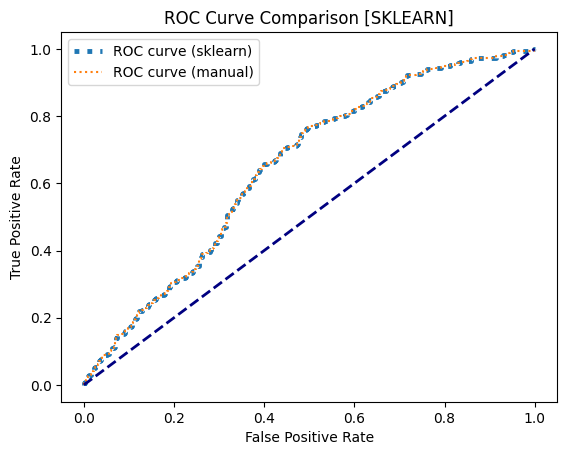

In [121]:
plt.plot(fpr_sklearn, tpr_sklearn, label='ROC curve (sklearn)', linestyle=':', linewidth=3.5)
plt.plot(FPR_manual, TPR_manual, label='ROC curve (manual)', linestyle=':')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

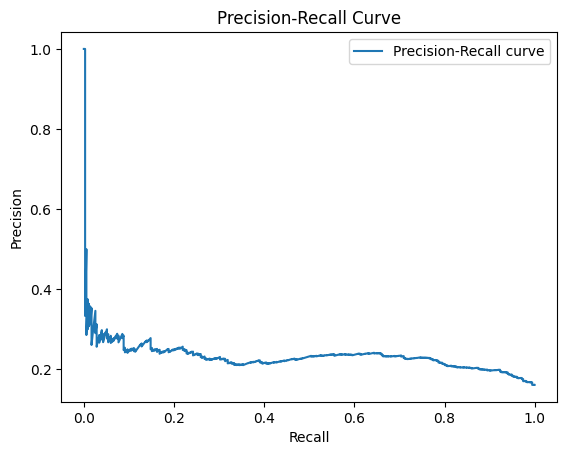

In [113]:
# 7. Построение графика Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, probs)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [114]:
# 8. Вычисление значения ROC-AUC метрики, используя метрики, посчитанные в пункте 3
roc_auc_manual = auc(FPR_manual, TPR_manual)
print("ROC-AUC (manual):", roc_auc_manual)

ROC-AUC (manual): 0.6481458013583219


# Вывод.

9.
(a) Модель работает чуть лучше рандома, стоит улучшить её гиперпараметры, а также провести лучшую предобработку данных.
(b) Да, может. Если roc кривая проходит ниже диагонали - это означает, что она предсказывает противоположный правильному классу значение. Например, если roc_auc_score у нас равен 0.2, то с вероятностью 80% модель предскажет неверный класс.